In [1]:
import astropy.io.fits as pf
import despyastro.wcsutil as wc
import healsparse as hs
import healpy as hp
import astropy.wcs as astrowcs

In [2]:
#This is data
hdr=pf.open('ADP.2016-10-06T13_11_50.182.fits.fz')
#hdr.info()

w=astrowcs.WCS(hdr[1].header)
print(w)
corners_image=w.calc_footprint(center=False)
print(corners_image)
corners_pixels=w.calc_footprint(center=True)
print(corners_pixels)
nx = hdr[1].header['naxis1']
ny = hdr[1].header['naxis2']

coords1 = corners_image[0]
coords2 = corners_image[1]
coords3 = corners_image[2]
coords4 = corners_image[3]


print(nx,ny)



# ra2 dec2               ra3 dec3
#    ------------------------
#    |                      |
#    |                      |
#    |                      |
#    |                      |
#    |                      |
#    |                      |
#    ------------------------
# ra1 dec1                  ra4 dec4

WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): (15653, 12767)

Pixel Dim  Data size  Bounds
        0      12767  None
        1      15653  None

World Dim  Physical Type  Units
        0  pos.eq.ra      deg
        1  pos.eq.dec     deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes
[[246.25357418 -30.62262115]
 [246.26688506 -32.10669103]
 [244.83790014 -32.10804944]
 [244.84697739 -30.62395631]]
[[246.25351952 -30.6226689 ]
 [246.26682867 -32.10664399]
 [244.83795639 -32.1080023 ]
 [244.84703219 -30.62400395]]
12767 15653


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


#nx = myhdr['naxis1']
#ny = myhdr['naxis2']
#print(f"nx, ny = {nx}, {ny}")
#print(myhdr['bitpix'])
#print(myhdr['BSCALE'])
#print(hdr[1].data[0,0])

In [3]:
#x,y=wcs.sky2image(245.55138714357247,-31.36722999489065,distort=False)
#print(x,y)

In [4]:
import numpy as np
image_data = pf.getdata('ADP.2016-10-06T13_11_50.182.fits.fz')#,do_not_scale_image_data=False,uint=False)
print(type(image_data))
print(image_data.shape)
print(image_data)
#flat_list = np.array(image_data[100])#[item for sublist in image_data for item in sublist])
#print(len(flat_list[flat_list>0]))
#print(flat_list[flat_list>0])


<class 'numpy.ndarray'>
(15653, 12767)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


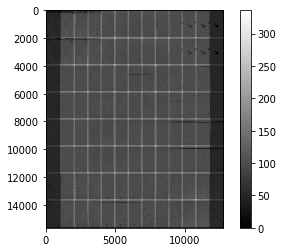

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.fliplr(image_data),cmap='gray')
plt.colorbar()
plt.savefig('test_image.png')

In [6]:
ra = [coords1[0],coords4[0],coords3[0],coords2[0]]
dec = [coords1[1],coords4[1],coords3[1],coords2[1]]
raC = (np.max(ra)+np.min(ra))/2.
decC = (np.max(dec)+np.min(dec))/2.
print(raC,decC)
nside = 2**17
poly = hs.Polygon(
        ra=ra,
        dec=dec,
        value=1)
smap = poly.get_map(nside=nside, dtype=np.int16)

245.55239259615672 -31.365335294695527


In [7]:
a = smap.validPixels
print(a)
print(len(a))
#values = np.array([1.]*len(a))
b=hp.nest2ring(nside,a)

raF,decF =hp.pix2ang(nside,a,lonlat=True,nest=True)
print(raF,decF)

[179562345941 179562345942 179562345943 ... 179944071171 179944071172
 179944071176]
8978144
[245.40950775 245.40882111 245.40916443 ... 245.32470703 245.32539368
 245.32402039] [-32.10921593 -32.10921593 -32.10887188 ... -30.62552657 -30.62552657
 -30.62552657]


In [8]:
hdr=pf.open('ADP.2016-10-06T13_11_50.182.fits.fz')

myhdr=hdr[1].header
wcs = wc.WCS(myhdr)
xn,yn = wcs.sky2image(raF,decF)
print(xn,yn)

[7660.56032354 7666.69474625 7663.6278021  ... 8431.32294168 8425.0908622
 8437.55502157] [1.56512249e+04 1.56512262e+04 1.56475966e+04 ... 3.94047175e+00
 3.93486607e+00 3.94611547e+00]


In [9]:
values = []
for x,y in zip(xn,yn):
    values.append(image_data[int(y-1),int(x-1)])

values = np.array(values)
print(values)


[0 0 0 ... 0 0 0]


8978144 8978144


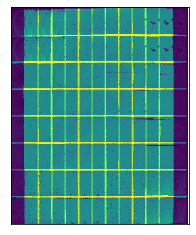

In [23]:
import skymap
from skymap import Skymap,McBrydeSkymap,OrthoSkymap


#radius=np.degrees(50*hp.nside2resol(32768))
m = Skymap(projection='cass', lon_0=raC, lat_0=decC,celestial=False,
               llcrnrlon=np.min(ra),urcrnrlon=np.max(ra),
               llcrnrlat=np.min(dec),urcrnrlat=np.max(dec),
               parallels=False, meridians=False)

m.draw_hpxmap(values,b,nside=nside,xsize=1000)
print(len(values),len(b))
plt.savefig('healpix_imageFull.png')

In [25]:
#Now low resolution:
hsp_map_2 = hs.HealSparseMap.makeEmpty(512, nside, dtype=np.int16)
print(values.dtype)
hsp_map_2.updateValues(a, values)
hsp_map_2.write('test_hsp_map.fits', clobber=True)

int16


HealSparseMap: nsideCoverage = 512, nsideSparse = 4096, float64
[175353853 175353854 175353855 ... 175726627 175726628 175726632] [ 33.59666667  40.45333333 105.20481928 ...   0.           0.
   0.        ]
[245.40161133 245.37963867 245.390625   ... 245.34667969 245.36865234
 245.32470703] [-32.11196835 -32.11196835 -32.10095914 ... -30.61570595 -30.61570595
 -30.61570595]
8978144 8978144


/home/carnero/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


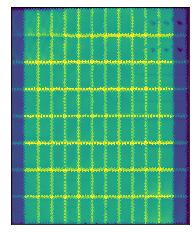

In [26]:
low_res_hsp = hsp_map_2.degrade(4096)
print(low_res_hsp)
j = low_res_hsp.validPixels

test_values_2 = low_res_hsp.getValuePixel(j)
print(j,test_values_2)

k=hp.nest2ring(4096,j)

raJ,decJ =hp.pix2ang(4096,j,lonlat=True,nest=True)
print(raJ,decJ)


#radius=np.degrees(50*hp.nside2resol(32768))
m = Skymap(projection='cass', lon_0=raC, lat_0=decC,celestial=False,
               llcrnrlon=np.min(ra),urcrnrlon=np.max(ra),
               llcrnrlat=np.min(dec),urcrnrlat=np.max(dec),
               parallels=False, meridians=False)

m.draw_hpxmap(test_values_2,k,nside=4096,xsize=1000)
print(len(values),len(b))
plt.savefig('healpix_imageLow.png')

hp_aux = np.zeros(hp.nside2npix(4096))+hp.UNSEEN
hp_aux[j] = test_values_2
hp.write_map('test_hp_map.fits', hp.ma(hp_aux), overwrite=True, nest=True, fits_IDL=False, partial=True)